# Figure 4 — Serial dependence for variable RI and ITI 

In [1]:
include("src/model.jl")
include("src/serialdep.jl")
include("src/fig_serialdep.jl");

In [2]:
serialdep_ris = [0, 1, 3, 6, 10]
serialdep_itis = [1, 3, 6, 10];

In [3]:
using DataFramesMeta

## 1. Data (Bliss 2017)

In [4]:
serialdep_exp_ri_y = [-1.72330045, 0.8502014, 1.51081313, 3.3679671, 2.86450525]
serialdep_exp_ri_e = [0.65, 0.4, 0.45, 0.5, 0.55] ./ 1.96

serialdep_exp_iti_y = [2.58877107, 2.97679619, 1.4154927, -1.37694445]
serialdep_exp_iti_e = [0.6, 0.45, 0.4, 0.825] ./ 1.96;

## 2. Simulation

### 2.1. RI

In [5]:
using FileIO
serialdep_sim_ri = load("data/fig4.jld2", "serialdep_sim_ri");

In [7]:
# intervals
ris = (1 .+ serialdep_ris) .* 1000
iti = 2000;

In [ ]:
nsubjects = 16
naug = 1000
nrepeats = 3

# main df
df_ri = DataFrame()

for subject in 1:nsubjects
    lg("$subject / $nsubjects")
    
    for ri in ris
        lg("$ri")
        
        # reset simulation
        sim = Simulation(1000, 16, 1; seed=SEEDS[subject])

        # get sequence
        timing = TimingCondition("bliss", iti, ri)
        cue = rand(1:sim.nstimuli)
        seq = getseq(sim, timing, cue; repeat=nrepeats)
        
        # run simulation
        _, _, rs = run!(sim, seq)
        
        # only keep cue and rs for timepoints after ri
        cues = map(s -> s[1], seq[1:2:end])
        rs   = rs[1:2:end,:,1]
        
        # get df with reports
        df = get_df_consecutive(sim, cues, rs; naug=naug)
        df.ri       = fill(ri,      nrow(df))
        df.subject  = fill(subject, nrow(df))
        
        compute_dist_error!(df)
        
        # append to big df
        append!(df_ri, df)
        
        @show getcapacity(sim, timing)
        @show (sim.R, sim.β)
        
        lg("")
    end
    
    lg("done")
end
;

In [27]:
# bliss uses error_to_mean (no fold) as error metric

In [18]:
x_sim_ri = []
y_sim_ri = []
e_sim_ri = []

params_sim_ri = zeros(length(ris), 2, nsubjects)
serialdep_sim_ri = zeros(length(ris), nsubjects)

for (i, ri) in enumerate(ris)
    x, y, e = smooth_serialdep_error(
        @subset(df_ri, :ri .== ri);
        distcol=:dist,
        errcol=:error_to_mean,
        win=π/6,
        step=π/100,
    )
    
    x_sim_ri = x
    push!(y_sim_ri, y)
    push!(e_sim_ri, e)
    
    # fit dog for each subject
    for (j, subject) in enumerate(1:nsubjects)
        p, dep = fit_dog(x, y[:,j])

        params_sim_ri[i,:,j] = p
        serialdep_sim_ri[i,j] = dep
    end
end

In [ ]:
fig = scatter_serialdep_error(@subset(df_ri, :ri .== ris[1]), :dist, :error_to_mean)
fix.ylim(-10, 10)

In [ ]:
i = 1

p = plot()
plot_serialdep_error!(p, x_sim_ri, y_sim_ri[i]; e=e_sim_ri[i], color=:black, label="")
for s in 1:nsubjects
    plot_serialdep_dog!(p, x_sim_ri, params_sim_ri[i,:,s]; color=:green, alpha=0.5, label="")
end
p

In [7]:
serialdep_sim_ri_y = rad2deg.(vec(mapslices(cmean, serialdep_sim_ri, dims=[2])))
serialdep_sim_ri_e = rad2deg.(vec(mapslices(cstde, serialdep_sim_ri, dims=[2])));

### 2.2. ITI

In [6]:
using FileIO
serialdep_sim_iti = load("data/fig4.jld2", "serialdep_sim_iti");

In [10]:
# intervals
ri   = 2000
itis = serialdep_itis .* 1000;

In [ ]:
nsubjects = 3
naug = 1000
nrepeats = 2 # 3

# main df
df_iti = DataFrame()

for subject in 1:nsubjects
    lg("$subject / $nsubjects")
    
    for iti in itis
        lg("$iti")
        
        # reset simulation
        sim = Simulation(1000, 16, 1; seed=SEEDS[subject])

        # get sequence
        timing = TimingCondition("bliss", iti, ri)
        cue = rand(1:sim.nstimuli)
        seq = getseq(sim, timing, cue; repeat=nrepeats)

        # run simulation
        _, _, rs = run!(sim, seq)
        
        # only keep cue and rs for timepoints after ri
        cues = map(s -> s[1], seq[1:2:end])
        rs   = rs[1:2:end,:,1]
        
        # get df with reports
        df = get_df_consecutive(sim, cues, rs; naug=naug)
        df.iti      = fill(iti,     nrow(df))
        df.subject  = fill(subject, nrow(df))
        
        compute_dist_error!(df)
        
        @show getcapacity(sim, timing)
        @show (sim.R, sim.β)
        
        # append to big df
        append!(df_iti, df)
        
        lg("")
    end
    
    lg("done")
end
;

In [35]:
x_sim_iti = []
y_sim_iti = []
e_sim_iti = []

params_sim_iti = zeros(length(itis), 2, nsubjects)
serialdep_sim_iti = zeros(length(itis), nsubjects)

for (i, iti) in enumerate(itis)
    x, y, e = smooth_serialdep_error(
        @subset(df_iti, :iti .== iti);
        distcol=:dist,
        errcol=:error_to_mean,
        win=π/6,
        step=π/50,
    )
    
    x_sim_iti = x
    push!(y_sim_iti, y)
    push!(e_sim_iti, e)
    
    # fit dog for each subject
    for subject in 1:nsubjects
        p, dep = fit_dog(x, y[:,subject])
        
        params_sim_iti[i,:,subject] = p
        serialdep_sim_iti[i,subject] = dep
    end
end

In [ ]:
i = 1

p = plot()
plot_serialdep_error!(p, x_sim_iti, y_sim_iti[i]; e=e_sim_iti[i], color=:black, label="")
for s in 1:nsubjects
    plot_serialdep_dog!(p, x_sim_iti, params_sim_iti[i,:,s]; color=:green, alpha=0.5, label="")
end
p

In [8]:
serialdep_sim_iti_y = rad2deg.(vec(mapslices(cmean, serialdep_sim_iti, dims=[2])))
serialdep_sim_iti_e = rad2deg.(vec(mapslices(cstde, serialdep_sim_iti, dims=[2])));

In [35]:
#using FileIO
#save("data/fig4.jld2", "serialdep_sim_ri", serialdep_sim_ri, "serialdep_sim_iti", serialdep_sim_iti)

## 3. Final figure

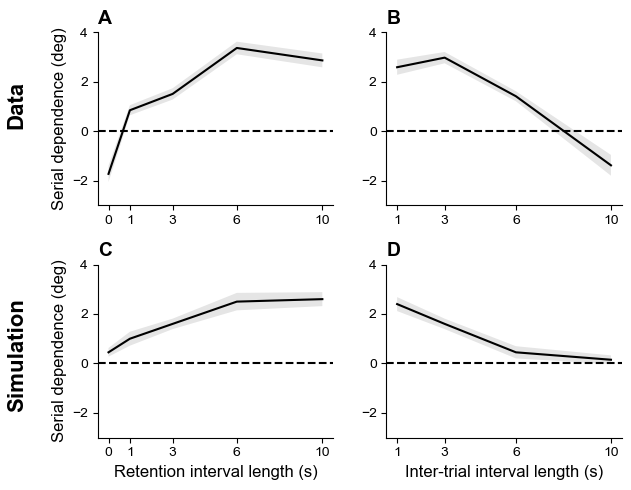

In [13]:
fig = figure("fig4_serialdep_ri_iti", figsize=(2/3 * 10, 5))

# A: RI
ax = subplot(221)
plt.title("A")
plot_serialdep_condition!(
    ax,
    serialdep_ris,
    serialdep_exp_ri_y;
    e=serialdep_exp_ri_e,
    xlabel="Retention interval length (s)",
    ylim=(-3,4)
)
ax.set_xlabel("")

# B: ITI
ax = subplot(222)
plt.title("B")
plot_serialdep_condition!(
    ax,
    serialdep_itis,
    serialdep_exp_iti_y;
    e=serialdep_exp_iti_e,
    xlabel="Inter-trial interval length (s)",
    ylim=(-3,4)
)
ax.set_xlabel("")
ax.set_ylabel("")


# C: RI
ax = subplot(223)
plt.title("C")
plot_serialdep_condition!(
    ax,
    serialdep_ris,
    serialdep_sim_ri_y;
    e=serialdep_sim_ri_e,
    xlabel="Retention interval length (s)",
    ylim=(-3,4)
)

# D: ITI
ax = subplot(224)
plt.title("D")
plot_serialdep_condition!(
    ax,
    serialdep_itis,
    serialdep_sim_iti_y;
    e=serialdep_sim_iti_e,
    xlabel="Inter-trial interval length (s)",
    ylim=(-3,4)
)
ax.set_ylabel("")

# Update the figure
fig.tight_layout(w_pad=2, rect=(0.05, 0, 0.95, 1)) # (left, bottom, right, top)

# add Data and Simulation annotations
annotate_data_simulation_side!();
#annotate_data_simulation_top!("RI", "ITI"; x1=0.33, x2=0.75);

In [15]:
fig.savefig("figs/fig4_serialdep_ri_iti.pdf");

### Check: fit DoG using Python and scipy.optimize.least_squares

In [84]:
using PyCall

py"""
import numpy as np
from scipy.optimize import least_squares

def dog(x, a, w):
    c = np.sqrt(2) / np.exp(-0.5)
    return x * a * w * c * np.exp(-(w * x) ** 2)

def fit_dog(y, x):

    def _solver(params):
        a, w = params
        return y - dog(x, a, w)

    min_a = -np.pi
    max_a = np.pi

    min_w = 0.4
    max_w = 4.0

    min_cost = np.inf
    for _ in range(200):
        params_0 = [np.random.rand() * (max_a - min_a) + min_a,
                    np.random.rand() * (max_w - min_w) + min_w]
        try:
            result = least_squares(_solver, params_0,
                                   bounds=([min_a, min_w],
                                           [max_a, max_w]))
        except ValueError:
            continue
        if result['cost'] < min_cost:
            best_params, min_cost = result['x'], result['cost']
    try:
        return best_params[0], best_params[1], min_cost
    except UnboundLocalError:
        return np.nan, np.nan, min_cost
"""

# a, w, cost = py"fit_dog"(y, x)